In [263]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from constants import WEIGHT_CONSTRAINT, SECTOR, SECTOR_CONSTRAINT

from pypfopt.plotting import plot_weights, plot_covariance

# pd.reset_option('display.float_format')
pd.options.display.float_format = lambda x: f'{x:.3f}'
plt.rcParams['font.family'] = 'Malgun Gothic'

In [264]:
def _allocation_risk(weights, covariances):

    # 가중치 분포의 위험(포트폴리오 위험?)을 계산한다.
    # 포트폴리오 위험의 값은 하나인데, [[x]] 같은 형태로 출력되므로 다음과 같이 작성하였다.
    # 여기서 주의할 점은 weight는 matrix 형태이어야 한다. 
    portfolio_risk = np.sqrt((weights * covariances * weights.T))[0, 0]

    # 포트폴리오 위험 값을 반환한다. 
    return portfolio_risk

In [265]:
def _assets_risk_contribution_to_allocation_risk(weights, covariances):

    # 가중치 분포의 위험(포트폴리오 위험?)을 계산한다.
    portfolio_risk = _allocation_risk(weights, covariances)

    # 가중치 분포의 위험(포트폴리오 위험)에 대한 각 자산의 기여도를 계산한다.
    # 각 자산의 위험 기여도인 만큼 값의 자산의 개수만큼 생성된다. 
    # 여기서 주의할 점은 weight는 matrix 형태이어야 한다. 
    assets_risk_contribution = np.multiply(weights.T, covariances * weights.T) \
        / portfolio_risk

    # 각 자산의 위험 기여도 값을 반환한다. 
    return assets_risk_contribution

In [266]:
def _risk_budget_objective_error(weights, args):

    # 공분산
    covariances = args[0]

    # 각 자산별 위험 예산
    assets_risk_budget = args[1]

    # 행렬로 바꿉니다. 
    weights = np.matrix(weights)

    # 포트폴리오 위험 값
    portfolio_risk = _allocation_risk(weights, covariances)

    # 각 자산의 위험 기여도 값
    assets_risk_contribution = \
        _assets_risk_contribution_to_allocation_risk(weights, covariances)

    # 각 자산의 목표 위험 기여도 값
    assets_risk_target = \
        np.asmatrix(np.multiply(portfolio_risk, assets_risk_budget))

    # (각 자산의 목표 위험 기여도 - 각 자산의 현재 위험 기여도 값)의 SSE
    error = \
        sum(np.square(assets_risk_contribution - assets_risk_target.T))[0, 0]

    # SSE 값 반환
    return error

In [267]:
def sector_lower_limits(x, sector_name):
    idx = np.where(np.array(list(SECTOR.values())) == sector_name)
    return np.sum(x[idx]) - SECTOR_CONSTRAINT[sector_name][0]/100

def sector_upper_limits(x, sector_name):
    idx = np.where(np.array(list(SECTOR.values())) == sector_name)
    return SECTOR_CONSTRAINT[sector_name][1]/100 - np.sum(x[idx])

lower_limits = [c[0]/100 for c in WEIGHT_CONSTRAINT.values()]
upper_limits = [c[1]/100 for c in WEIGHT_CONSTRAINT.values()]


In [268]:
def _get_risk_parity_weights(covariances, assets_risk_budget, initial_weights):

    # 최적화 과정에서 고려해야 할 제약 조건을 다음과 같이 설정합니다.
    # 'eq': 등식(=0)을 의미함, 'ineq' : 부등식(≥0)을 의미합니다.
    constraints = ({'type': 'ineq', 'fun': lambda x: 1.0 - np.sum(x)},

                   # 각 상품군의 상하한선
                   {'type': 'ineq', 'fun': lambda x: np.array(upper_limits) - x},
                   {'type': 'ineq', 'fun': lambda x: x - np.array(lower_limits)},

                    # 각 자산군의 상한선
                   {'type': 'ineq', 'fun': lambda x: sector_upper_limits(x, "local_stock")},
                   {'type': 'ineq', 'fun': lambda x: sector_upper_limits(x, "foreign_stock")},
                   {'type': 'ineq', 'fun': lambda x: sector_upper_limits(x, "bond")},
                   {'type': 'ineq', 'fun': lambda x: sector_upper_limits(x, "commodity")},
                   {'type': 'ineq', 'fun': lambda x: sector_upper_limits(x, "inverse")},
                   {'type': 'ineq', 'fun': lambda x: sector_upper_limits(x, "fx")},
                   {'type': 'ineq', 'fun': lambda x: sector_upper_limits(x, "cash")},

                   # 각 자산군의 하한선
                   {'type': 'ineq', 'fun': lambda x: sector_lower_limits(x, "local_stock")},
                   {'type': 'ineq', 'fun': lambda x: sector_lower_limits(x, "foreign_stock")},
                   {'type': 'ineq', 'fun': lambda x: sector_lower_limits(x, "bond")},
                   {'type': 'ineq', 'fun': lambda x: sector_lower_limits(x, "commodity")},
                   {'type': 'ineq', 'fun': lambda x: sector_lower_limits(x, "inverse")},
                   {'type': 'ineq', 'fun': lambda x: sector_lower_limits(x, "fx")},
                   {'type': 'ineq', 'fun': lambda x: sector_lower_limits(x, "cash")},
                   )

    # ftol(반복 계산 시 종료를 위한 허용치)은 작게 할수록, 
    # maxiter는 크게 할수록 더 정확한 답을 찾으나 계샨량이 늘어납니다.
    options = {'ftol': 1e-20, 'maxiter': 800}


    # (각 자산의 목표 위험 기여도 - 각 자산의 현재 위험 기여도 값)의 SSE 값을 최소화하는 과정
    optimize_result = minimize(fun=_risk_budget_objective_error,
                               x0=initial_weights,
                               args=[covariances, assets_risk_budget],
                               method='SLSQP', # Sequential Least Squares Programming
                               constraints=constraints,
                               options=options)

    # 최적화 과정에서 나온 가중치 값 저장
    weights = optimize_result.x

    # 최적 자산 비중치 반환
    return weights, optimize_result

In [269]:
def get_weights_with_result():

    global prices, covariances
    # data 폴더에 있는 수정주가 데이터를 불러옵니다. 
    prices = pd.read_csv("./data/adjclose.csv", 
                         parse_dates=True, 
                         header=8, 
                         index_col='Name', 
                         skiprows=range(9, 14), 
                         thousands=',')       
    prices.index.name = 'date'
    prices = prices.astype(float)

    # 주간 수익률을 기준으로 공분산을 구하고, 이를 연 단위로 바꿔줍니다.
    covariances = 52.0 * \
        prices.asfreq('W-FRI').pct_change().dropna().cov().values

    # 각 자산이 포트폴리오 위험에 기여하는 수준이 모두 동일하게 가져가기 위해 다음과 같이 설정합니다.
    # 이 부분을 변경하면 각 자산이 포트폴리오 위험에 기여하는 수준을 필요에 맞게 맞춰줄 수 있습니다. 
    # prices.shape[1] = 자산의 개수
    assets_risk_budget = [1 / prices.shape[1]] * prices.shape[1]

    # 초기 비중을 모두 동일하게 가져갑니다. 
    init_weights = [1 / prices.shape[1]] * prices.shape[1]

    # 리스크 패리티 전략에 맞게 자산 비중의 최적화를 진행합니다.
    # 최초 비중, 각 자산의 위험 예산, 공분산 값을 통해 리스크 패리티 전략에 따른 각 자산의 비중을 구합니다. 
    weights, optimize_result = \
        _get_risk_parity_weights(covariances, assets_risk_budget, init_weights)

    # 각 자산 비중을 판다스 시리즈 형태로 전환합니다.
    weights = pd.Series(weights, index=prices.columns, name='weight')

    # 최적의 비중을 반환합니다. 
    return weights, optimize_result

In [270]:
n_weights, n_optimize_result = get_weights_with_result()

In [271]:
result_risk_contribution = _assets_risk_contribution_to_allocation_risk(np.matrix(n_weights.values), covariances)
result_risk_contribution = pd.Series(np.array(result_risk_contribution).squeeze(), index=prices.columns, name='risk_contribution')
result_portfolio_risk = _allocation_risk(np.matrix(n_weights.values), covariances)

In [272]:
n_optimize_result

     fun: 8.474192282623144e-05
     jac: array([ 1.80928648e-03,  1.80928649e-03,  3.51378685e-05,  3.51378640e-05,
        3.51378758e-05,  3.51378658e-05, -2.45791271e-05, -2.45791243e-05,
       -2.45791225e-05, -1.05506206e-06, -1.05505660e-06,  7.87451719e-04,
        2.37736789e-04, -1.05506388e-06, -1.05506570e-06])
 message: 'Optimization terminated successfully'
    nfev: 3687
     nit: 190
    njev: 186
  status: 0
 success: True
       x: array([ 5.59686311e-02,  4.40313689e-02,  2.35653718e-02,  2.13157835e-02,
        2.15502514e-02,  3.35685933e-02,  2.92544429e-01,  2.45091945e-01,
        6.23636265e-02,  5.69443537e-02,  2.08192360e-02, -3.97806015e-20,
        8.74715537e-19,  6.78815884e-02,  5.43548219e-02])

<AxesSubplot:xlabel='Weight'>

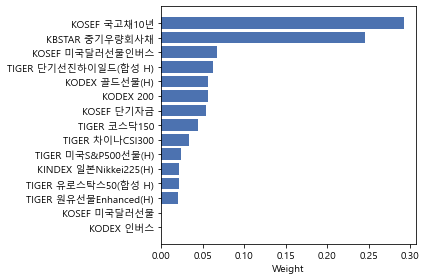

In [275]:
plot_weights(n_weights)
# pd.DataFrame(n_weights).plot(kind='bar')

<AxesSubplot:>

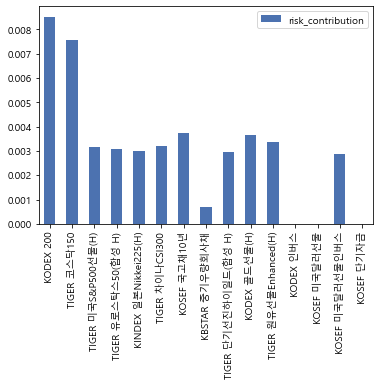

In [276]:
pd.DataFrame(result_risk_contribution).plot(kind='bar')